In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/vuhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

- This works ia trying  to build a machine learning model using Naive Bayes rules that predicts which Tweets are about real disasters and which one’s aren’t.

In [2]:
df = pd.read_csv('/Users/vuhan/Desktop/JOHN/Online Course/Coursera/Natural Language Processing/Week1/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets = df[['id', 'text', 'target']]
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [4]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

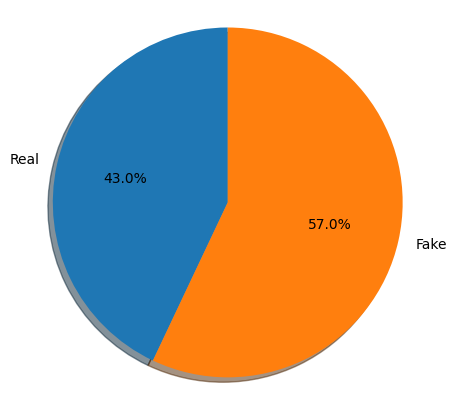

In [5]:
fig = plt.figure(figsize=(5, 5))

labels = 'Real', 'Fake'

sizes = [len(tweets.loc[tweets['target'] == 1]), len(tweets.loc[tweets['target'] == 0])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

## Preprocessing Data

In [6]:
def process_tweets(tweet, stem=True):
    
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    stopwords_eng = stopwords.words('english')
    tweet_clean = []
    for word in tweet_tokens:
        if word not in stopwords_eng and word not in string.punctuation:
            tweet_clean.append(word)
    if stem==False:
        return tweet_clean
    else:    
        tweet_stem = []
        stemmer = PorterStemmer()
        for word in tweet_clean:
            stem_word = stemmer.stem(word)
            tweet_stem.append(stem_word)
        return tweet_stem

In [7]:
def build_freqs(label, tweets):
    y_list = np.squeeze(label).tolist()
    
    freqs = {}
    
    for y, tweet in zip(y_list, tweets):
        for word in process_tweets(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [8]:
tweet = tweets['text']
label = tweets['target']

freqs = build_freqs(label, tweet)

In [9]:
def word_count_table(sample):
    keys = process_tweets(sample)
    
    data = []
    for word in keys:
        real = 0
        fake = 0
        
        if (word, 1) in freqs:
            real = freqs.get((word, 1), 0)
        if (word, 0) in freqs:
            fake = freqs.get((word, 0), 0)
        data.append([word, real, fake])
    return data

In [10]:
freqs

{('deed', 1): 1,
 ('reason', 1): 8,
 ('earthquak', 1): 47,
 ('may', 1): 50,
 ('allah', 1): 6,
 ('forgiv', 1): 1,
 ('us', 1): 49,
 ('forest', 1): 50,
 ('fire', 1): 272,
 ('near', 1): 49,
 ('la', 1): 21,
 ('rong', 1): 1,
 ('sask', 1): 1,
 ('canada', 1): 8,
 ('resid', 1): 9,
 ('ask', 1): 5,
 ('shelter', 1): 7,
 ('place', 1): 17,
 ('notifi', 1): 1,
 ('offic', 1): 41,
 ('evacu', 1): 102,
 ('order', 1): 25,
 ('expect', 1): 22,
 ('13,000', 1): 1,
 ('peopl', 1): 106,
 ('receiv', 1): 4,
 ('wildfir', 1): 80,
 ('california', 1): 111,
 ('got', 1): 29,
 ('sent', 1): 4,
 ('photo', 1): 29,
 ('rubi', 1): 1,
 ('alaska', 1): 5,
 ('smoke', 1): 14,
 ('pour', 1): 2,
 ('school', 1): 32,
 ('rockyfir', 1): 4,
 ('updat', 1): 37,
 ('hwi', 1): 11,
 ('20', 1): 13,
 ('close', 1): 30,
 ('direct', 1): 6,
 ('due', 1): 24,
 ('lake', 1): 9,
 ('counti', 1): 31,
 ('cafir', 1): 2,
 ('flood', 1): 120,
 ('disast', 1): 120,
 ('heavi', 1): 18,
 ('rain', 1): 39,
 ('caus', 1): 63,
 ('flash', 1): 17,
 ('street', 1): 24,
 ('manit

## Training Naive Bayes

In [11]:
def number_word_per_class(frequency):
    N_real = N_fake = 0
    for pair in frequency.keys():
        if pair[1] > 0:
            N_real += frequency[pair]
        else:
            N_fake += frequency[pair]
    return N_real, N_fake

In [12]:
n_real, n_fake = number_word_per_class(freqs)

In [13]:
def vocabulary(frequency):
    vocab = [x[0] for x in frequency.keys()]
    V = len(set(vocab))
    
    return vocab, V

In [14]:
vocab, V = vocabulary(freqs)

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})\tag{3}$$

In [15]:
def log_prior(X, y):
    D = len(y)
    D_real = len(y[y==1])
    D_fake = len(y[y==0])
    logprior = np.log(D_real / D) - np.log(D_fake / D)
    return logprior, D_real, D_fake

#### Positive and Negative Probability of a Word
To compute the positive probability and the negative probability for a specific word in the vocabulary, we'll use the following inputs:

- $freq_{pos}$ and $freq_{neg}$ are the frequencies of that specific word in the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.
- $N_{pos}$ and $N_{neg}$ are the total number of positive and negative words for all documents (for all tweets), respectively.
- $V$ is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We'll use these to compute the positive and negative probability for a specific word using this formula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

Notice that we add the "+1" in the numerator for additive smoothing.  This [wiki article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations:

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

In [16]:
def training_naive_bayes(frequency, X, y):
        N_real, N_fake = number_word_per_class(frequency)
        vocab, V = vocabulary(frequency)
        logprior, D_real, D_fake = log_prior(X, y)
        
        loglikelihood = {}
        
        for word in vocab:
            freq_real = frequency.get((word, 1), 0)
            freq_fake = frequency.get((word, 0), 0)
            
            p_w_real = (freq_real + 1) / (N_real + V)
            p_w_fake = (freq_fake + 1) / (N_fake + V)
            
            loglikelihood[word] = np.log(p_w_real / p_w_fake)
        return logprior, loglikelihood

In [17]:
y = tweets['target'].values
X = tweets['text']

In [18]:
logprior, loglikelihood = training_naive_bayes(freqs, X, y)

In [19]:
print(logprior)
print(len(loglikelihood))

-0.2832393228998533
12459


In [20]:
def predicting_naive_bayes(tweet, logprior, loglikelihood):
    new_word = process_tweets(tweet)
    p = 0
    p += logprior
    for word in new_word:
        for word in loglikelihood:
            p += loglikelihood[word]
    return p

In [21]:
tweet[10]

'Three people died from the heat wave so far'

In [22]:
p = predicting_naive_bayes(tweet[10], logprior, loglikelihood)
print('The expected output is: {}'.format(p))

The expected output is: -3019.0294935274956


In [23]:
def testing_naive_bayes(X_test, y_test, logprior, loglikelihood):
    accuracy = 0
    yhat = []
    for tweet in X_test:
        if predicting_naive_bayes(tweet, logprior, loglikelihood) > 0:
            yhat_i = 1
        else:
            yhat_i = 0
        yhat.append(yhat_i)
    
    error = np.sum(np.asarray(yhat) != y_test) / (len(y_test))
    accuracy = 1 - error
    
    return accuracy

In [24]:
tmp_res = testing_naive_bayes(X, y, logprior, loglikelihood)

print('Naive Bayes accuracy = {:.4f}'.format(tmp_res))

Naive Bayes accuracy = 0.5703


In [25]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    p = predicting_naive_bayes(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

I am happy -> -503.41
I am bad -> -503.41
this movie should have been great. -> -1006.53
great -> -503.41
great great -> -1006.53
great great great -> -1509.66
great great great great -> -2012.78


## Visualizing Naive Bayes

In [26]:
def extract_loglikelihood(tweet):
    word_l = process_tweets(tweet)
    x = np.zeros(2)
    for word in word_l:
        x[0] += newlog.get((word, 1), 0)
        x[1] += newlog.get((word, 0), 0)
        
    x = x[np.newaxis, :]
    return x

In [27]:
N_real, N_fake = number_word_per_class(freqs)
vocab, V = vocabulary(freqs)
logprior, D_real, D_fake = log_prior(X, y)

newlog = {}

for word in vocab:
    freq_real = freqs.get((word, 1), 0)
    freq_fake = freqs.get((word, 0), 0)

    p_w_real = (freq_real + 1) / (N_real + V)
    p_w_fake = (freq_fake + 1) / (N_fake + V)

    newlog[(word, 1)] = np.log(p_w_real)
    newlog[(word, 0)] = np.log(p_w_fake)

In [28]:
tweet = tweets['text']
label = tweets['target']

In [29]:
data = np.zeros((len(tweet), 2))

for i in range(len(tweet)):
    data[i, :] = extract_loglikelihood(tweet[i])

In [30]:
visual_data = pd.DataFrame(data, columns = ['Reals', 'Fakes'])
visual_data['sentiment'] = y

visual_data

,Reals,Fakes,sentiment
0,-57.862964,-59.567702,1
1,-54.979561,-63.444768,1
2,-88.532874,-99.004350,1
3,-51.126256,-62.113107,1
4,-73.972354,-76.915095,1
...,...,...,...
7608,-58.186807,-66.637509,1
7609,-63.512946,-72.034260,1
7610,-58.437423,-72.685961,1
7611,-113.259053,-126.526201,1


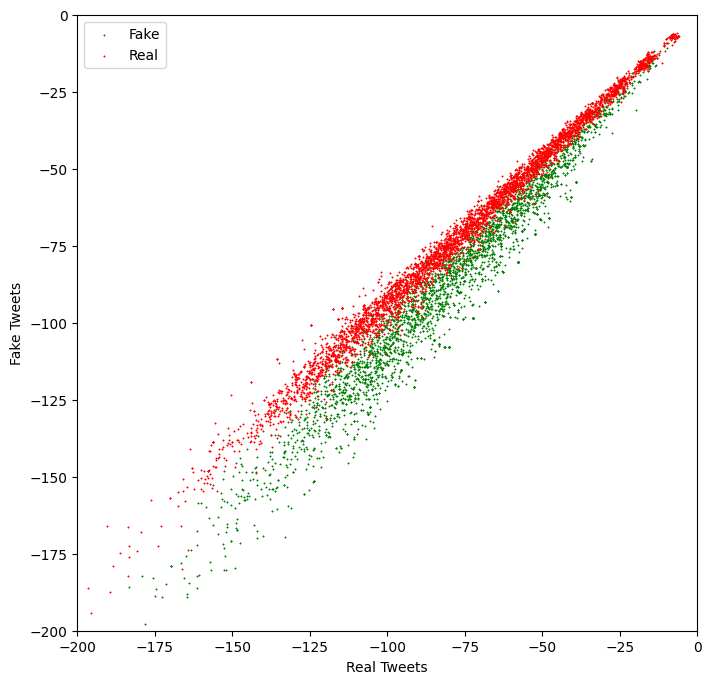

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'green']
sentiments = ['Real', 'Fake']

index = visual_data.index

for sentiment in visual_data['sentiment'].unique():
    ix = index[visual_data['sentiment'] == sentiment]
    ax.scatter(visual_data.iloc[ix].Reals, visual_data.iloc[ix].Fakes,
               c = colors[int(sentiment)], s=0.1, marker='*', label=sentiments[int(sentiment)])
    
ax.legend(loc='best')

plt.xlim([-200, 0])
plt.ylim([-200, 0])
plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')
plt.show()

## Using Confidence Ellipses to interpret Naïve Bayes

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

A confidence ellipse is a way to visualize a 2D random variable. It is a better way than plotting the points over a cartesian plane because, with big datasets, the points can overlap badly and hide the real distribution of the data. Confidence ellipses summarize the information of the dataset with only four parameters: 

* Center: It is the numerical mean of the attributes
* Height and width: Related with the variance of each attribute. The user must specify the desired amount of standard deviations used to plot the ellipse. 
* Angle: Related with the covariance among attributes.

The parameter __n_std__ stands for the number of standard deviations bounded by the ellipse. Remember that for normal random distributions:


* About 68% of the area under the curve falls within 1 standard deviation around the mean.
* About 95% of the area under the curve falls within 2 standard deviations around the mean.
* About 99.7% of the area under the curve falls within 3 standard deviations around the mean.




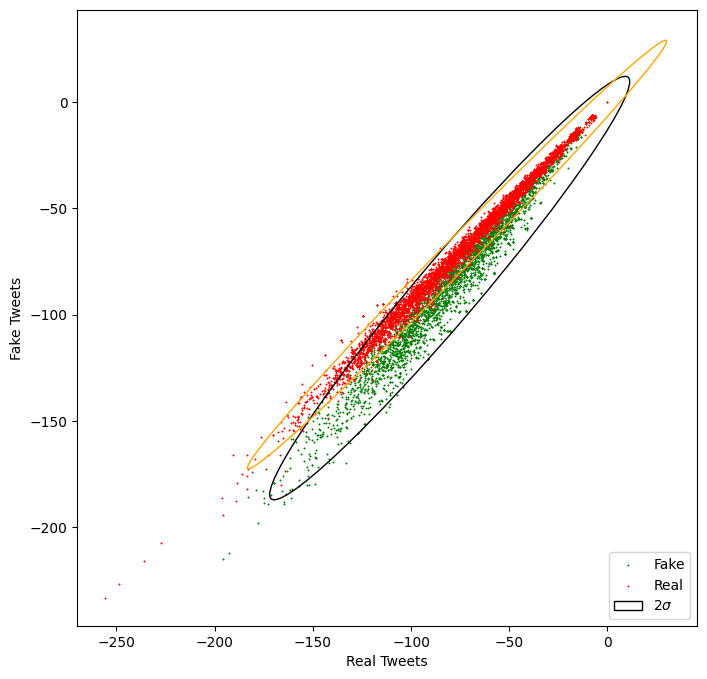

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'green']
sentiments = ['Real', 'Fake']

index = visual_data.index

for sentiment in visual_data['sentiment'].unique():
    ix = index[visual_data['sentiment'] == sentiment]
    ax.scatter(visual_data.iloc[ix].Reals, visual_data.iloc[ix].Fakes,
               c = colors[int(sentiment)], s=0.1, marker='*', label=sentiments[int(sentiment)])

plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')

visual_real = visual_data[visual_data['sentiment'] == 1]
visual_fake = visual_data[visual_data['sentiment'] == 0]

confidence_ellipse(visual_real.Reals, visual_real.Fakes, ax, n_std=3, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(visual_fake.Reals, visual_fake.Fakes, ax, n_std=3, edgecolor='orange')
ax.legend(loc='lower right')
plt.show()